In [2]:
#Common Variables
PROCESSEDBODY = "output/processed_body.csv"
PROCESSEDOUTPUT = "output/processed_final.csv"

In [3]:
import os
import string
import pandas as pd
import numpy as np
import gensim
import unicodedata
from gensim import corpora
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from gensim.models import CoherenceModel, LdaModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

import json
import re
import html
import warnings
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

C:\Users\user\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [13]:
# nltk.download('stopwords')
# nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [4]:
stemmer = PorterStemmer()
pyLDAvis.enable_notebook() 
current_dir = os.getcwd()
coherence_scores = []

In [5]:
stop_words_set = set()
stop_words = set(stopwords.words('english'))
for word in stop_words:
    if('\'' in word):
        stop_words_set.add(word.strip().replace('\'', ''))
    stop_words_set.add(word)

In [6]:
def preprocess_text(text):
    # remove non ascii
    text = unicodedata.normalize('NFKD', text).encode(
        'ascii', 'ignore').decode('utf-8', 'ignore')
    text = text.lower()
    # unescaping
    text = html.unescape(text)
    text = re.sub(r'<code>(.|\n)*?</code>','', text) # removing <code>...</code>
    text = re.sub(r'<a.*?</a>', '', text)  # removing whole anchor tags
    text = re.sub(r'(<.*?>)', '', text)  # removing html markup
    text = re.sub(r'[^\w\s]', '', text)  # removing punctuation
    text = re.sub(r'[\d]', '', text)  # removing digits
    # remove stopwords
    tokenized = []
    for word in text.split():
        if word in stop_words_set:
            continue
        tokenized.append(word)
        
    for i in range(len(tokenized)):
        word = tokenized[i]
        word = WordNetLemmatizer().lemmatize(word, pos='v')
        tokenized[i] = stemmer.stem(word)
    return tokenized

In [8]:
df=pd.read_csv(PROCESSEDBODY)
df['preprocessed'] = ""
for i in range(len(df)):
    df['preprocessed'].iloc[i] = preprocess_text(df.raw.iloc[i])
df.to_csv(PROCESSEDOUTPUT)
df.head()

,id,qa,raw,preprocessed
0,42,q,Best way to allow plugins for a PHP applicatio...,"[best, way, allow, plugin, php, applic, start,..."
1,328,q,PHP Session Security <p>What are some guidelin...,"[php, session, secur, guidelin, maintain, resp..."
2,549,q,The definitive guide to form-based website aut...,"[definit, guid, formbas, websit, authent, form..."
3,580,q,Deploying SQL Server Databases from Test to Li...,"[deploy, sql, server, databas, test, live, won..."
4,2056,q,What are MVP and MVC and what is the differenc...,"[mvp, mvc, differ, look, beyond, dragdrop, con..."


In [9]:
def create_dir(parent_dir, dir_name):
    temp = os.path.join(parent_dir,dir_name)
    try:  
        os.mkdir(temp)  
    except OSError as error:  
        
        pass
    return temp

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [06:43<00:00, 14.95s/it]


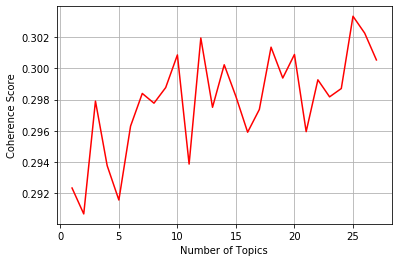

In [10]:
# finding out optimum topic number
data = df['preprocessed']
dictionary = gensim.corpora.Dictionary(data)
corpus = [dictionary.doc2bow(doc) for doc in data]
coherence_scores = []
for num_topics in tqdm(range(1,28)):
    lda = LdaModel(corpus=corpus, num_topics=num_topics,id2word=dictionary, alpha=50/num_topics)
    coherenceModel = CoherenceModel(model=lda, texts=data, dictionary=dictionary, coherence='c_v')
    score = coherenceModel.get_coherence()
    coherence_scores.append([num_topics,score])
# save scores as csv
ch_df = pd.DataFrame(coherence_scores,columns=['Num Topic','Score'])
ch_df.to_csv('output/Coherence_Scores.csv')
# plot
plt.xlabel('Number of Topics') 
plt.ylabel('Coherence Score') 
x = []
y = []
for score in coherence_scores:
    x.append(score[0])
    y.append(score[1])
plt.plot(x,y,c='r')
plt.gca().set_aspect('auto')
plt.grid()
plt.savefig('output/scores.png', dpi=500)
plt.show()

In [16]:
res_dir = create_dir(current_dir, 'Topic Modeling Results')
data = df['preprocessed']
dictionary = gensim.corpora.Dictionary(data)
corpus = [dictionary.doc2bow(doc) for doc in data]

# create folder for topic number
NUM_TOPIS = [5,6,10,7,8,13,9,11,15]
for num_topics in NUM_TOPIS:
    topic_dir = create_dir(res_dir, f'{num_topics} Topics')
    if os.path.isfile(os.path.join(topic_dir, 'lda.pkl')):
        lda = pickle.load(open(os.path.join(topic_dir, 'lda.pkl'), "rb"))
    else:
        lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha=50/num_topics)
        # save the model as pickle
        pickle.dump(lda, open(os.path.join(topic_dir, 'lda.pkl'), "wb"))
        
    topics = [[(word, word_prob) for word, word_prob in lda.show_topic(
        n, topn=30)] for n in range(lda.num_topics)]
    # term-topic matrix
    topics_df = pd.DataFrame([[f'{word} {round(word_prob,4)}' for word, word_prob in topic] 
                              for topic in topics], columns=[
        f'Term {i}' for i in range(1, 31)], index=[f'Topic {n}' for n in range(lda.num_topics)]).T
    
    topics_df.to_csv(os.path.join(topic_dir, 'term x topic.csv'))
    # topic words
    topic_words_dir = create_dir(topic_dir, 'TopicWords')
    for n in range(num_topics):
        topic_words_df = pd.DataFrame(
            [[word_prob, word]for word, word_prob in topics[n]], columns=['Prob', 'Word'])
        
        topic_words_df.to_csv(os.path.join(topic_words_dir, f'{n}.csv'))
        
    # post to dominant topic
    corpus_topic_df = pd.DataFrame()

    corpus_topic_df['qa'] = df.qa
    
    topic_model_results = lda[corpus]
    corpus_topics = [sorted(doc, key=lambda x: -x[1])[0]
                    for doc in topic_model_results]
    
    corpus_topic_df['Dominant Topic'] = [item[0] for item in corpus_topics]
    corpus_topic_df['Correlation'] = [item[1] for item in corpus_topics]
    
    corpus_topic_df.to_csv(os.path.join(topic_dir, 'postToTopic.csv'))
    topic_to_post_dir = create_dir(topic_dir, 'TopicToPost')
    
    for i in range(num_topics):
        temp = create_dir(topic_to_post_dir, str(i))
        temp_q_df = corpus_topic_df.loc[corpus_topic_df['Dominant Topic'] == i]
        temp_q_df = temp_q_df.loc[temp_q_df['qa'] == 'q']
        temp_a_df = corpus_topic_df.loc[corpus_topic_df['Dominant Topic'] == i]
        temp_a_df = temp_a_df.loc[temp_a_df['qa'] == 'a']
        temp_q_df.drop(columns=['Dominant Topic','qa']).to_csv(
            os.path.join(temp, 'Questions.csv'), index=False)
        temp_q_df.drop(columns=['Dominant Topic','qa']).to_excel(
            os.path.join(temp, 'Questions.xlsx'), index=False)
        temp_a_df.drop(columns=['Dominant Topic','qa']).to_csv(
            os.path.join(temp, 'Answers.csv'), index=False)
        temp_a_df.drop(columns=['Dominant Topic','qa']).to_excel(
            os.path.join(temp, 'Answers.xlsx'), index=False)
        
    # post count under any topic
    topic_post_cnt_df = corpus_topic_df.groupby('Dominant Topic').agg(
        Document_Count=('Dominant Topic', np.size),
        Percentage=('Dominant Topic', np.size)).reset_index()
    
    topic_post_cnt_df['Percentage'] = topic_post_cnt_df['Percentage'].apply(
        lambda x: round((x*100) / len(corpus), 2))
    
    topic_post_cnt_df.to_csv(os.path.join(topic_dir, 'postPerTopic.csv'))
    
    # pyLDAvis
    vis = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)
    
    pyLDAvis.save_html(vis, os.path.join(topic_dir, f'pyLDAvis.html'))